In [35]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm
from time import time

from sklearn.metrics import confusion_matrix, mean_absolute_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
import xgboost as xgb
import eli5
import joblib
import seaborn as sns


# Prepare sample dataset

In [37]:
df_read=pd.read_parquet(f'../../data/olist/df1_all.parquet')
print(df_read.shape)
df_read.head()

(112650, 70)


,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,price,freight_value,order_item_count,...,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad
0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,borda da mata,MG,moveis_decoracao,para de minas,MG,199.00,17.87,1.0,...,0.0,0.0,2.6,0.0,0.000000,0,0,1,1,0
1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,franca,SP,perfumaria,atibaia,SP,12.99,12.79,1.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0
2,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,sao paulo,SP,telefonia,guararapes,SP,19.90,11.85,1.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0
3,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,sao paulo,SP,beleza_saude,santos,SP,145.95,11.65,1.0,...,1.0,1.0,-0.2,1.0,1.000000,1,1,0,1,1
4,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,beleza_saude,piracicaba,SP,59.99,8.88,1.0,...,4.0,0.4,1.4,5.0,0.227273,0,0,1,1,0


In [32]:
col_id=[
    'order_id', 'order_item_id', 'customer_id','customer_unique_id'
]
col_id2=[
    'product_id','seller_id'
]
col_cat=[
    'seller_city','seller_state','product_category_name','customer_city','customer_state'
]
col_itemorders_cat=[
    'order_status'
]
col_itemorders_num=[
    'price', 'freight_value','order_item_count', 'num_uniq_prod','price_freight_value'
]
col_review=[
    'num_reviews_per_order','review_score', 'sent_score', 'sent_magnitude', 'sentences_count','token_count', 
    't_answer_first',  't_answer_last','t_answer_all','t_review_create_delivered',  't_review_create_estimated'
]
col_time=[
    't_approved',  't_logist_warehouse',  't_logist_fact',  't_logist_estimated',  't_logist_transport_days',  
    't_logist_transport_hours','t_delay',  't_delay_negative','status_delay',  'status_cancelled'
]  
col_timeline=[
    'product_days_in_sales_before',  'product_days_in_sales_after', 'num_day_timeline'
]  
col_product_total=[
    'prod_price_freight_value_sum_sum',  'prod_price_freight_value_sum_mean', 'prod_price_freight_value_sum_std' 
] 
col_product_roll=[
    'prod_price_freight_value_sum_rol_sum','prod_price_freight_value_sum_rol_mean',  'prod_price_freight_value_sum_rol_std'
]
col_product_expand=[
    'prod_price_freight_value_sum_expand_sum',  'prod_price_freight_value_sum_expand_mean', 'prod_price_freight_value_sum_expand_std'
]
col_review_total=[
    'prod_review_score_sum_sum',  'prod_review_score_sum_mean','prod_review_score_bad_sum_count',  'prod_review_score_good_sum_count',
    'prod_review_message_is_sum_count',  'prod_review_message_is_bad_sum_count','prod_sent_score_sum_sum',  'prod_client_not_happy_sum_count'
] 
col_review_expand= [
    'prod_review_score_sum_expand_sum',  'prod_review_score_count_expand_count', 'prod_review_score_sum_expand_mean',
    'prod_review_score_bad_sum_expand_count',  'prod_review_score_good_sum_expand_count','prod_review_message_is_sum_expand_count',  
    'prod_review_message_is_bad_sum_expand_count', 'prod_review_message_is_bad_sum_expand_rate','prod_sent_score_sum_expand_sum', 
    'prod_client_not_happy_sum_expand_count', 'prod_review_score_bad_sum_expand_rate2'
]
col_label=[
    'client_not_happy','review_score_bad','review_score_good','review_message_is',  'review_message_is_bad'
]
col_all_num=col_itemorders_num+col_review+col_time+col_timeline+col_product_total+col_product_roll+col_product_expand+col_review_total+col_review_expand+col_label
col_all_cat=col_id2+col_cat+col_itemorders_cat

In [42]:
%%time
df_read['product_category_name'].fillna('0',inplace=True)
encoder = OrdinalEncoder()
df_tmp1 = encoder.fit_transform(df_read[col_all_cat])
df_tmp2=pd.DataFrame(df_tmp1, columns=col_all_cat)
df=df_read[col_all_num].join(df_tmp2, how='inner')
del df_tmp1, df_tmp2


CPU times: total: 266 ms
Wall time: 260 ms


# Function

In [39]:
def conf_matr(y,y_pred):
    cm=confusion_matrix(y,y_pred)
    tn,fp,fn,tp=cm.ravel()
    r=tp/(tp+fn)
    p=tp/(tp+fp)
    f1=2*(r*p)/(r+p)
    print('confusion matrix:')
    print(cm)
    print('recall: {}, precision: {}, f1: {}'.format(r,p,f1))

In [40]:
def check_log_model_regr(df, feats, column_label, model, cv=4, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df[column_label].isnull() ].copy()

    X = df_train[feats]
    y = df_train[column_label]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

def check_log_model_class(df, feats, column_label, model, cv=4, scoring=confusion_matrix, show_eli5=True):
    df_train = df[ ~df[column_label].isnull() ].copy()

    X = df_train[feats]
    y = df_train[column_label]
    
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    accuracys=[]
    nda=np.array([[0, 0], [0, 0]])
  

    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        score = scoring(y_test, y_pred, labels=model.classes_)
        nda=nda+np.array(score)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracys.append(accuracy)

      
        
    result= np.mean(accuracys), nda
    
    
    sns.heatmap(nda, annot=True, fmt='d', cmap='Blues')
    if show_eli5:
        model.fit(X, y)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

# Regression

**"Assess the probability of returning a customer"**
- Since there are very few records in the database with repeated orders for one client, we will transform the task into **Estimate the probability of choosing a particular product by a new or repeat client**.
- I don’t use the average check indicator, since orders with one position prevail in orders and there is no potential to increase the cost of an order on average. But there is a potential for an increase in the number of orders over a certain period of time, which directly affects the average daily sales.
- Hypothesis: goods that, according to the totality of characteristics observed by the client, are more preferable in his eyes, should sell better and, therefore, sales after this order should be better than before the order. And vice versa.
- To evaluate it, we will use **"The average daily amount of sales in the period from the date of the order to the last date of sale of this product** 

- as features I will use only those that are available to the client at the time of the order and directly affect his choice, as well as product parameters and some indicators that are known to the supplier (for example, the average daily sales amount at the time of a new order)

- I delete products from the dataset that (one of the options):
    - sold only once in all time (there is no statistically significant history for them);
    - the first sale of goods (since the average daily sales before it is impossible to calculate);
    - the last sale of the item (because average daily sales after it cannot be calculated).

- (Of course, the dataset was reduced by almost 2 times, but rows without a predictive value would create extra noise for the regression model. If necessary, you can do a cluster analysis to understand how, for example, products sold only once differ from other products).

In [43]:
f1= df['product_days_in_sales_before']!=0
f2= df['product_days_in_sales_after']!=0
df_reg=df[(f1) & (f2)].copy()
df_reg['mean_sales_per_day_before']=df_reg['prod_price_freight_value_sum_expand_sum']/df_reg['product_days_in_sales_before']
df_reg['mean_sales_per_day_after']=(df_reg['prod_price_freight_value_sum_sum']-df_reg['prod_price_freight_value_sum_expand_sum'])/df_reg['product_days_in_sales_after']
df_reg.head(2)

,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,...,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status,mean_sales_per_day_before,mean_sales_per_day_after
2,19.90,11.85,1.0,1.0,31.75,1.0,4.0,0.0,0.0,0.0,...,18181.0,1371.0,517.0,22.0,71.0,1515.0,25.0,2.0,4.482143,0.705577
4,59.99,8.88,1.0,1.0,68.87,1.0,5.0,0.4,0.4,1.0,...,27627.0,2481.0,483.0,22.0,12.0,2860.0,25.0,2.0,8.552669,18.983196


In [45]:
from sklearn.dummy import DummyRegressor
feats = ["product_id"]
X = df_reg[feats]
y = df_reg["mean_sales_per_day_after"]

model = DummyRegressor(strategy="mean")
model.fit(X, y)
y_pred = model.predict(X)

print('Dummy-mean: ',mean_absolute_error(y, y_pred))

model = DummyRegressor(strategy="median")
model.fit(X, y)
y_pred = model.predict(X)

print('Dummy-median:' ,mean_absolute_error(y, y_pred))

Dummy-mean:  32.872698429853536
Dummy-median: 26.669633768228348


## Option 1. All fields

In [46]:
feats = list(df_reg.columns) 
col_label='mean_sales_per_day_after'
feats.remove(col_label) 
check_log_model_regr(df_reg, feats, col_label, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:04,  1.23s/it]


(4.702074523181091, 0.1811931672363883)


Weight,Feature
0.2765,prod_price_freight_value_sum_rol_sum
0.2621,prod_price_freight_value_sum_sum
0.1011,product_days_in_sales_after
0.0541,prod_price_freight_value_sum_std
0.0412,prod_price_freight_value_sum_mean
0.0289,prod_price_freight_value_sum_expand_mean
0.0175,prod_review_message_is_sum_count
0.0144,prod_price_freight_value_sum_rol_std
0.0139,order_item_count
0.0137,prod_review_score_sum_sum


## Option 2. After simple tuning hyperparameters

In [47]:
feats=[
    'price', 'freight_value','prod_review_score_bad_sum_expand_count','prod_review_score_good_sum_expand_count',
    'product_id', 'seller_id', 'product_category_name', 'customer_city']
col_label='mean_sales_per_day_after' 

check_log_model_regr(df_reg, feats, col_label, xgb.XGBRegressor(max_depth=11, n_estimators=500, learning_rate=0.3, random_state=0))

4it [00:27,  6.76s/it]


(6.817036372633531, 0.3477594363701459)


Weight,Feature
0.2267,prod_review_score_good_sum_expand_count
0.2208,price
0.1594,product_category_name
0.1455,seller_id
0.1135,product_id
0.0938,prod_review_score_bad_sum_expand_count
0.0239,freight_value
0.0163,customer_city


# Classification

**"Predict customer satisfaction"**
- In this case, we will consider an unsatisfied customer as someone who either gave a bad rating (1.2), or wrote a text review with a negative tone, or both. Since a number of orders contained several ratings, the data from the last review was taken as the final customer satisfaction.

- Hypothesis: if some parameters of the client’s interaction with the marketplace during the process of ordering a product and its actual receipt, as well as his consumer experience in relation to the product received, deviated significantly from expectations, then with a high probability the client will respond to this with bad ratings and comments.

- we will use the entire dataset, without cutting, as in the regression problem, since we predict the result of each transaction

## Option 1. 

4it [00:02,  1.42it/s]


(0.9069596252983664, array([[89922,  1612],
       [ 8869, 12247]], dtype=int64))


Weight,Feature
0.4076,prod_review_score_bad_sum_expand_count
0.3260,prod_review_score_good_sum_expand_count
0.0901,t_delay
0.0651,status_cancelled
0.0388,t_logist_fact
0.0181,t_answer_first
0.0096,t_logist_estimated
0.0082,price_freight_value
0.0082,product_category_name
0.0081,customer_city


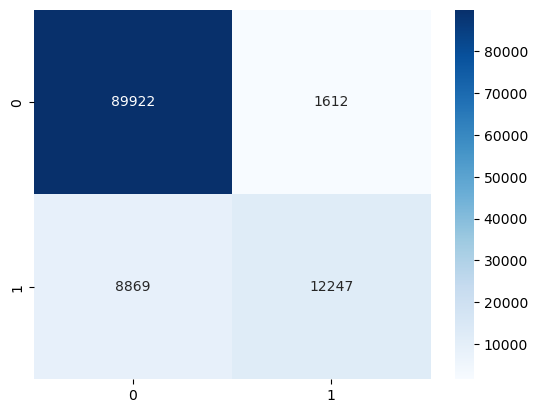

In [48]:
feats=['price_freight_value', 't_answer_first', 
       't_logist_fact', 't_logist_estimated', 't_delay', 't_delay_negative', 'status_delay', 'status_cancelled', # logistik
       'prod_review_score_bad_sum_expand_count', 'prod_review_score_good_sum_expand_count', # evaluation indicators at the time of order - this is the formation of customer expectations
       'product_id', 'seller_id', 'product_category_name', 'customer_city','order_status']

col_label='client_not_happy' 
check_log_model_class(df, feats, col_label, xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:01,  3.30it/s]


(0.9061251848548338, array([[90020,  1514],
       [ 9061, 12055]], dtype=int64))


Weight,Feature
0.4436,prod_review_score_bad_sum_expand_count
0.3313,prod_review_score_good_sum_expand_count
0.0782,t_delay
0.0378,t_answer_first
0.0322,t_logist_fact
0.0312,t_delay_negative
0.0188,status_cancelled
0.0101,t_logist_estimated
0.0043,product_category_name
0.0043,customer_city


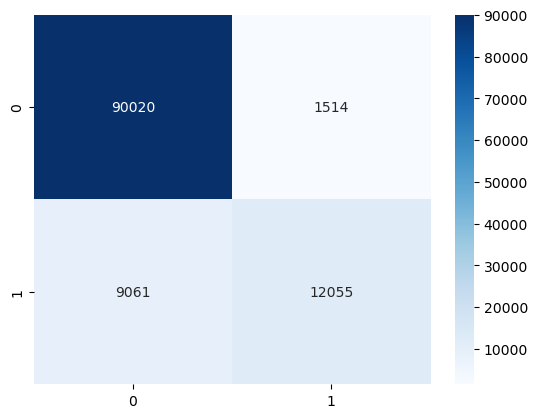

In [50]:
check_log_model_class(df, feats, col_label, CatBoostClassifier(depth=5, iterations=50, loss_function='Logloss', learning_rate=0.3, random_state=0, verbose=False))

## Option 2. 

4it [01:34, 23.59s/it]


(0.9332800656368514, array([[89333,  2201],
       [ 5315, 15801]], dtype=int64))
CPU times: total: 32min 2s
Wall time: 2min 4s


Weight,Feature
0.2383,prod_client_not_happy_sum_expand_count
0.2188,prod_review_score_bad_sum_expand_rate2
0.0787,prod_review_score_good_sum_expand_count
0.0510,t_review_create_estimated
0.0491,order_item_count
0.0411,num_uniq_prod
0.0369,status_cancelled
0.0285,prod_review_score_sum_expand_mean
0.0236,t_review_create_delivered
0.0192,product_days_in_sales_before


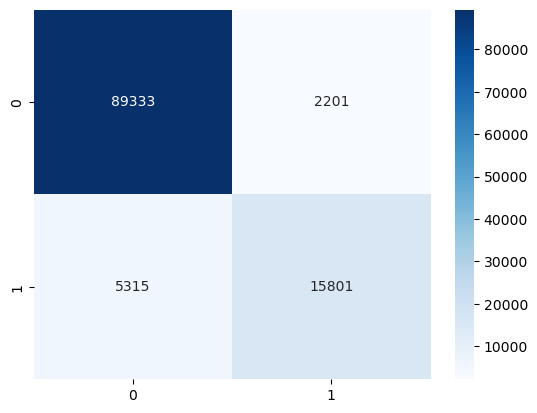

In [62]:
%%time
feats=['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       't_answer_first', 't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_delay','t_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before',
       'num_day_timeline', 'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 'prod_review_score_sum_expand_sum',
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_count',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
       'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state', 'order_status'
     
]

col_label='client_not_happy'
check_log_model_class(df, feats, col_label, xgb.XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.3, random_state=0))

4it [00:42, 10.61s/it]


(0.9323391015050885, array([[89379,  2155],
       [ 5467, 15649]], dtype=int64))
CPU times: total: 9min 43s
Wall time: 54.4 s


Weight,Feature
0.5361,prod_client_not_happy_sum_expand_count
0.0629,order_item_count
0.0326,prod_review_score_sum_expand_sum
0.0300,product_days_in_sales_before
0.0249,prod_review_score_bad_sum_expand_rate2
0.0246,t_answer_first
0.0245,num_uniq_prod
0.0195,prod_review_score_sum_expand_mean
0.0170,t_review_create_estimated
0.0161,prod_sent_score_sum_expand_sum


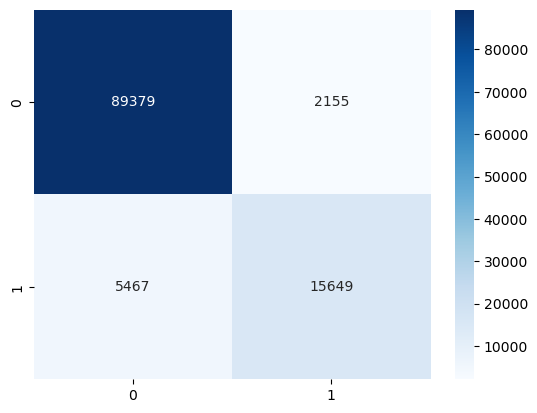

In [63]:
%time check_log_model_class(df, feats, col_label, CatBoostClassifier(depth=5, iterations=1000, loss_function='Logloss', learning_rate=0.3, random_state=0, verbose=False))